# UK Traffic Safety Data 2005-2017

data source:
[Kaggle Data Set](https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles)

P: Preprocess (Scale, normalize, dummies, pipeline)  
S: Split (train/validate/test sets)  
D: Define (the model to use)  
F: Fit  
P: Predict  
E: Evaluate (metrics, classification report, cross validation)  
O: Optimise (GridSearch, RandomizedSearch)  
S: Save  


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!pip install mplleaflet

In [4]:
#homedir='/content/drive/My Drive/Colab Data/'
#datadir=homedir+'data/UK-Traffic-Safety/'

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import datetime as dt
import cartopy
import cartopy.crs as ccrs
plt.style.use('seaborn-white')
%matplotlib notebook

## Load the Data
Load the accidents data

In [6]:
#accidents = pd.read_csv(datadir+'Accident_Information.zip')
accidents = pd.read_csv('./data/Accident_Information.csv')

/home/mogmelon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
accidents.shape

(2047256, 34)

This is a pretty big dataset so let's check the columns and data types. 

In [8]:
print(accidents.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 34 columns):
Accident_Index                                 object
1st_Road_Class                                 object
1st_Road_Number                                float64
2nd_Road_Class                                 object
2nd_Road_Number                                float64
Accident_Severity                              object
Carriageway_Hazards                            object
Date                                           object
Day_of_Week                                    object
Did_Police_Officer_Attend_Scene_of_Accident    float64
Junction_Control                               object
Junction_Detail                                object
Latitude                                       float64
Light_Conditions                               object
Local_Authority_(District)                     object
Local_Authority_(Highway)                      object
Location_Easting_OS

The time and date aren't datetime objects so let's fix that.

In [9]:
accidents['Time']= pd.to_datetime(accidents['Time'], format="%H:%M").dt.time
accidents['Date']= pd.to_datetime(accidents['Date'], format="%Y-%m-%d")

Im going to use a classifier with dummy variables. Times and dates are continuous so let's group them into periods of the day and seasons of the year.

In [10]:
def period(hour):
    if hour >= dt.time(7,0) and hour < dt.time(9,30):
        return "morning_rush"
    elif hour >= dt.time(9,30) and hour < dt.time(15,0):
        return "daytime"
    elif hour >= dt.time(15,0) and hour < dt.time(18,0):
        return "evening_rush"
    elif hour >= dt.time(18,0) and hour < dt.time(0,0):
        return "evening"
    else:
        return "night"
    
accidents['Period'] = accidents['Time'].apply(period)  

In [11]:
def season(month):
    if month >= 3 and month < 6:
        return "sprint"
    elif month >= 6 and month < 9:
        return "summer"
    elif month >= 9 and month < 11:
        return "autumn"
    else:
        return "winter"
accidents['Month']=pd.DatetimeIndex(accidents['Date']).month
accidents['Season'] = accidents['Month'].apply(season)  

Some columns contain a lot of NaN values. Let's have a look at these and start eliminating some features which are unlikely to add a lot of value to the classifier.

In [12]:
print(accidents.isna().sum())

Accident_Index                                      0
1st_Road_Class                                      0
1st_Road_Number                                     2
2nd_Road_Class                                 844272
2nd_Road_Number                                 17593
Accident_Severity                                   0
Carriageway_Hazards                                 0
Date                                                0
Day_of_Week                                         0
Did_Police_Officer_Attend_Scene_of_Accident       278
Junction_Control                                    0
Junction_Detail                                     0
Latitude                                          174
Light_Conditions                                    0
Local_Authority_(District)                          0
Local_Authority_(Highway)                           0
Location_Easting_OSGR                             164
Location_Northing_OSGR                            164
Longitude                   

These are the columns with a large number of NaNs or or columns which are unlikely to be useful in classification

In [13]:
drop_cols=['2nd_Road_Class', '2nd_Road_Number', 'Did_Police_Officer_Attend_Scene_of_Accident', 
           'LSOA_of_Accident_Location', 'Pedestrian_Crossing-Human_Control', 
           'Local_Authority_(District)', 'Local_Authority_(Highway)',
           'Pedestrian_Crossing-Physical_Facilities', 'InScotland', 'Time', 'Month', 'Date']

In [14]:
accidents.drop(columns=drop_cols, inplace=True)

Let's check again how many NaNs are left. There aren't many and we have plenty of data so we will remove these rows. 

In [15]:
print(accidents.isna().sum())

Accident_Index                  0
1st_Road_Class                  0
1st_Road_Number                 2
Accident_Severity               0
Carriageway_Hazards             0
Day_of_Week                     0
Junction_Control                0
Junction_Detail                 0
Latitude                      174
Light_Conditions                0
Location_Easting_OSGR         164
Location_Northing_OSGR        164
Longitude                     175
Number_of_Casualties            0
Number_of_Vehicles              0
Police_Force                    0
Road_Surface_Conditions         0
Road_Type                       0
Special_Conditions_at_Site      0
Speed_limit                    37
Urban_or_Rural_Area             0
Weather_Conditions              0
Year                            0
Period                          0
Season                          0
dtype: int64


In [16]:
accidents = accidents.dropna()

The Accident_Index is no use for classification, but I'll save it for later or for joining the vehicles data set if required.  

In [17]:
accidents_index=['Accident_Index']
accidents.drop(columns='Accident_Index', inplace=True)

## Preprocessing
I'm intending to use a Gradient Boosted classifier or Random Forest. In sk-learn these require numerical features so I need to select the training columns and create dummy variables from any categorical columns. 

In [18]:
train_cols=['1st_Road_Class', '1st_Road_Number', 'Carriageway_Hazards',
               'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Latitude', 
               'Light_Conditions', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 
               'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
               'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Year', 'Period', 'Season']

In [19]:
categorical_cols=['1st_Road_Class', 'Carriageway_Hazards', 'Day_of_Week', 
                   'Junction_Control', 'Junction_Detail', 'Light_Conditions',
                   'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
                   'Urban_or_Rural_Area', 'Weather_Conditions', 'Year', 'Period', 'Season']

separate remain columns as numerical

In [20]:
numerical_cols=list(set(train_cols)-set(categorical_cols))
numerical_cols

['Speed_limit',
 'Number_of_Casualties',
 'Longitude',
 'Number_of_Vehicles',
 'Latitude',
 '1st_Road_Number']

## Split 
Separate into features (X) and target (y). Im also going to take a quick look at the fatal accidents and save a separate dataframe to use later. 

In [21]:
X=accidents[train_cols]
y=accidents['Accident_Severity']
fatal=accidents[accidents['Accident_Severity']=='Fatal']

<IPython.core.display.Javascript object>


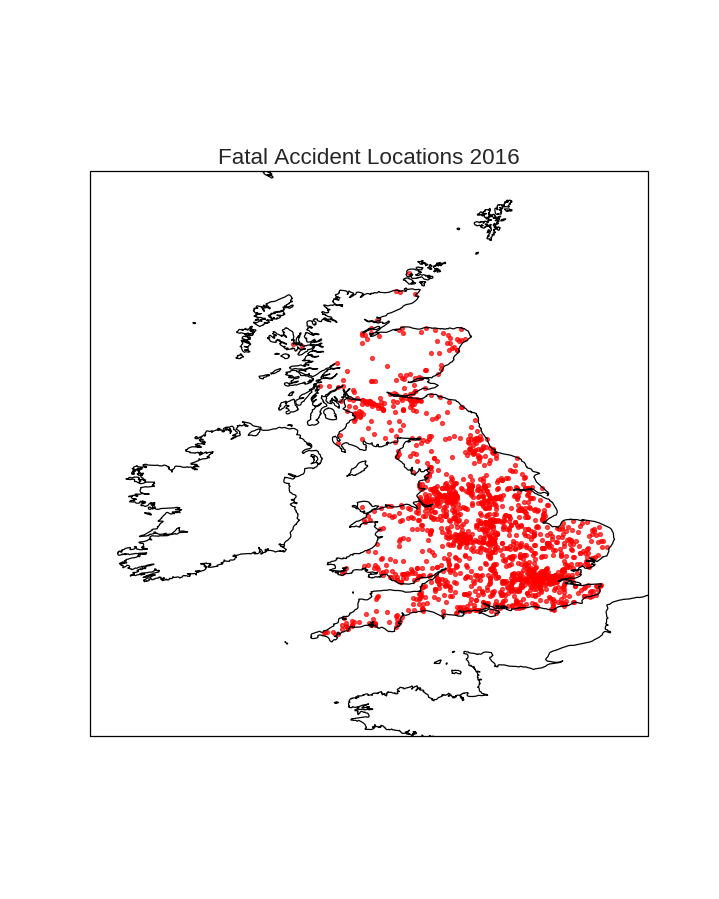

In [78]:
import cartopy
import cartopy.crs as ccrs
year=2016
data=fatal[fatal['Year']==year]
lons=data["Longitude"].tolist()
lats=data["Latitude"].tolist()

plt.figure(figsize=(8,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([(min(lons)-5), (max(lons)+1), (min(lats)-2.5), (max(lats)+2.5)],
                crs = ccrs.PlateCarree())

ax.coastlines(resolution='10m', color='black', linewidth=1) 
ax.scatter(lons, lats, c='r', alpha=0.7, s=10)
plt.title('Fatal Accident Locations %s' % str(year), size=18)

plt.show()

create the dummy variables and check the new shape of the data.

In [19]:
X=pd.get_dummies(X[categorical_cols]).join(X[numerical_cols])

In [20]:
X.shape

(2047042, 91)

Create out train, validate and test sets and check the shapes. 
This is a 60/20/20 split.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1228224, 91) (1228224,)
(409409, 91) (409409,)
(409409, 91) (409409,)


## More Preprocessing - Scaling
To get the best results from the Gradient Boosted Classifier the data needs to be scaled. I've applit the MinMaxScaler to all categorical values to scale them to a value between 1 and 0 based on the max/min in the sample.

In [22]:
scale_cols=["Longitude", "Latitude", 'Number_of_Casualties', 
            'Number_of_Vehicles', "Speed_limit", "Year", "1st_Road_Number"]
scaler=preprocessing.MinMaxScaler()
X_train[scale_cols]= scaler.fit_transform(X_train[scale_cols])
X_val[scale_cols] = scaler.transform(X_val[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])
X_train.head()


/home/mogmelon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mogmelon/.local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Year,1st_Road_Class_A,1st_Road_Class_A(M),1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Carriageway_Hazards_Any animal in carriageway (except ridden horse),Carriageway_Hazards_Data missing or out of range,Carriageway_Hazards_None,...,Season_autumn,Season_sprint,Season_summer,Season_winter,Speed_limit,Number_of_Casualties,Longitude,Latitude,1st_Road_Number,Number_of_Vehicles
8727,0.000000,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0.333333,0.000000,0.810736,0.148437,0.101110,0.015152
888664,0.333333,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0.666667,0.046512,0.460357,0.139073,0.423142,0.015152
979259,0.416667,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0.333333,0.000000,0.666212,0.293930,0.601960,0.015152
1922657,1.000000,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0.333333,0.000000,0.809424,0.137017,0.025103,0.015152
1423668,0.666667,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0.500000,0.000000,0.639958,0.298865,0.000600,0.000000


## Gradient Boosted Classifier
Gradient Boosted classifier first

In [23]:
clf = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.1, max_depth = 5, random_state = 0)

Fit the Model

In [25]:
clf.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(clf.score(X_val, y_val)))

Accuracy score (training): 0.848
Accuracy score (validation): 0.847


These scores are ok, but given the amount of data we should be able to improve them.  
Let's carry on for now and make some prediciton and check the classification report. 

Predict GBC

In [26]:
y_val_preds  = clf.predict(X_val)

Check the classification report and the feature importances

In [27]:
report = classification_report(y_val, y_val_preds)
print('Classification Report: \n', report)

Classification Report: 
               precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00      5370
     Serious       0.64      0.00      0.00     57272
      Slight       0.85      1.00      0.92    346767

    accuracy                           0.85    409409
   macro avg       0.49      0.33      0.31    409409
weighted avg       0.81      0.85      0.78    409409



The classification report shows poor performance in the minority classes 'Fatal' and 'Serious'. The macro averaged values are much lower than our reasonable accuracy scores above.  
We need to develop the model to address the imbalances, but first let's have a look at the feature importances and try another type of classifier. 

Text(0.5, 0, 'Relative Feature Importance with GBC')

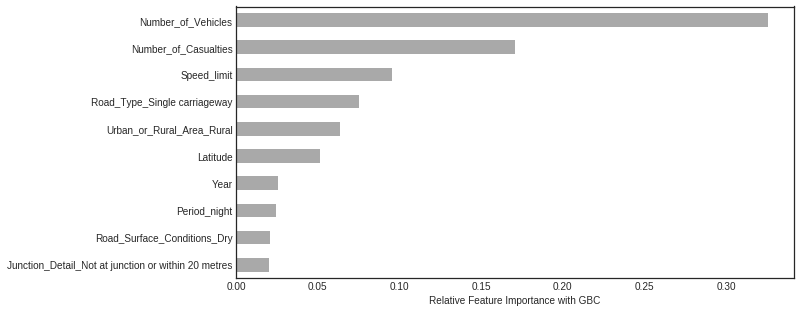

In [36]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with GBC')

## Random Forest

In [31]:
rf = RandomForestClassifier(random_state=0, criterion='entropy', n_jobs=-1, class_weight='balanced')

Fit

In [32]:
rf.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(rf.score(X_val, y_val)))

Accuracy score (training): 1.000
Accuracy score (validation): 0.844


Predict Random Forest

In [33]:
y_val_preds  = rf.predict(X_val)

Check the classification report and the feature importances

In [34]:
report = classification_report(y_val, y_val_preds)
print('Classification Report Random Forest: \n', report)

Classification Report Random Forest: 
               precision    recall  f1-score   support

       Fatal       0.08      0.00      0.00      5370
     Serious       0.27      0.01      0.03     57272
      Slight       0.85      0.99      0.92    346767

    accuracy                           0.84    409409
   macro avg       0.40      0.34      0.31    409409
weighted avg       0.76      0.84      0.78    409409



Text(0.5, 0, 'Relative Feature Importance with Random Forest')

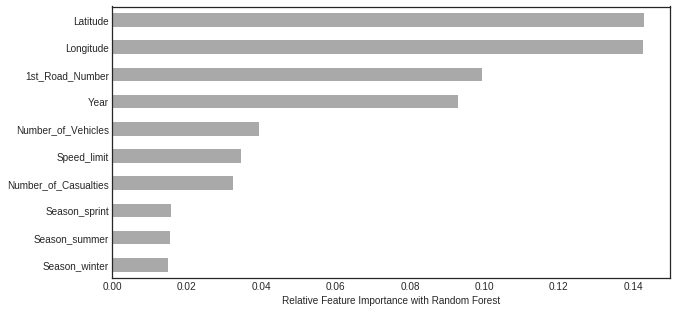

In [35]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with Random Forest')

## TBC